In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-zip/yelp_zip.csv


# Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, classification_report
# from imblearn.under_sampling import ClusterCentroids
from sklearn.decomposition import PCA

import scipy as sp

import cupy
import cuml
import cudf

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# Датасет

In [4]:
df_origin = cudf.read_csv('/kaggle/input/yelp-zip/yelp_zip.csv')
df_origin

,Unnamed: 0,user_id,prod_id,rating,label,date,review,prod_name
0,0,5044,0,1.0,-1,2014-11-16,"Drinks were bad, the hot chocolate was watered...",Toast
1,1,5045,0,1.0,-1,2014-09-08,This was the worst experience I've ever had a ...,Toast
2,2,5046,0,3.0,-1,2013-10-06,This is located on the site of the old Spruce ...,Toast
3,3,5047,0,5.0,-1,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,Toast
4,4,5048,0,5.0,-1,2014-08-28,I love Toast! The food choices are fantastic -...,Toast
...,...,...,...,...,...,...,...,...
608453,608453,119664,5039,4.0,1,2013-01-20,When I first moved to the area I must say I wa...,Best Subs the
608454,608454,56277,5039,2.0,1,2012-11-12,Kind of pricey. I guess I expected a ridiculou...,Best Subs the
608455,608455,265320,5039,1.0,1,2012-08-22,"Stopped by this restaurant yesterday, we just ...",Best Subs the
608456,608456,161722,5039,4.0,1,2011-05-11,Finally checked out The Best Subs in Claremont...,Best Subs the


In [5]:
df = df_origin.copy()
df

,Unnamed: 0,user_id,prod_id,rating,label,date,review,prod_name
0,0,5044,0,1.0,-1,2014-11-16,"Drinks were bad, the hot chocolate was watered...",Toast
1,1,5045,0,1.0,-1,2014-09-08,This was the worst experience I've ever had a ...,Toast
2,2,5046,0,3.0,-1,2013-10-06,This is located on the site of the old Spruce ...,Toast
3,3,5047,0,5.0,-1,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,Toast
4,4,5048,0,5.0,-1,2014-08-28,I love Toast! The food choices are fantastic -...,Toast
...,...,...,...,...,...,...,...,...
608453,608453,119664,5039,4.0,1,2013-01-20,When I first moved to the area I must say I wa...,Best Subs the
608454,608454,56277,5039,2.0,1,2012-11-12,Kind of pricey. I guess I expected a ridiculou...,Best Subs the
608455,608455,265320,5039,1.0,1,2012-08-22,"Stopped by this restaurant yesterday, we just ...",Best Subs the
608456,608456,161722,5039,4.0,1,2011-05-11,Finally checked out The Best Subs in Claremont...,Best Subs the


# Предобработка

In [6]:
# функция предобработки текста
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_review(text):
    cl_text = text.lower().strip()
    cl_text = re.sub(r"[^\w\s]", "", cl_text)
    words = word_tokenize(cl_text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

example = 'this is the (test) example for preprocessing function 123 8done 8 :!?!'
print(preprocess_review(example))

test example preprocessing function 123 8done 8


In [7]:
df= df.drop(['Unnamed: 0', 'user_id',	'prod_id', 'date'], axis=1)
df

,rating,label,review,prod_name
0,1.0,-1,"Drinks were bad, the hot chocolate was watered...",Toast
1,1.0,-1,This was the worst experience I've ever had a ...,Toast
2,3.0,-1,This is located on the site of the old Spruce ...,Toast
3,5.0,-1,I enjoyed coffee and breakfast twice at Toast ...,Toast
4,5.0,-1,I love Toast! The food choices are fantastic -...,Toast
...,...,...,...,...
608453,4.0,1,When I first moved to the area I must say I wa...,Best Subs the
608454,2.0,1,Kind of pricey. I guess I expected a ridiculou...,Best Subs the
608455,1.0,1,"Stopped by this restaurant yesterday, we just ...",Best Subs the
608456,4.0,1,Finally checked out The Best Subs in Claremont...,Best Subs the


In [8]:
df_cpu = df.to_pandas()

In [9]:
df_cpu['review'] = df_cpu['review'].apply(preprocess_review)

In [10]:
df = cudf.from_pandas(df_cpu)
df

,rating,label,review,prod_name
0,1.0,-1,drink bad hot chocolate watered latte burnt ta...,Toast
1,1.0,-1,worst experience ive ever casual coffeelight f...,Toast
2,3.0,-1,located site old spruce st video mild cofee go...,Toast
3,5.0,-1,enjoyed coffee breakfast twice toast recent vi...,Toast
4,5.0,-1,love toast food choice fantastic love serve br...,Toast
...,...,...,...,...
608453,4.0,1,first moved area must say wasnt fan sub huge m...,Best Subs the
608454,2.0,1,kind pricey guess expected ridiculously huge s...,Best Subs the
608455,1.0,1,stopped restaurant yesterday wanted quick sand...,Best Subs the
608456,4.0,1,finally checked best sub claremont nh today re...,Best Subs the


# Методы визуализации метрик

In [11]:
def show_metrics(y_true, y_pred, title):
    print(f'''
                {title}
==========================================
 auc: {roc_auc_score(y_true, y_pred)}             
==========================================
 report:                                
{classification_report(y_true, y_pred)}
==========================================

    ''')

In [12]:
def show_confusion_matrix(y_true, y_pred, title_string):
    conf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.title(title_string)
    sns.heatmap(conf, fmt='d', annot=True)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()

In [13]:
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score,
    recall_score, 
    f1_score, 
    classification_report,
    confusion_matrix,
    average_precision_score
)

def show_classification_report(y_true, y_pred):
    """
    Выводит основные метрики классификации в консоль
    
    Параметры:
    y_true - истинные метки
    y_pred - предсказанные метки
    """
    y_test_numpy, y_pred_numpy = cupy.asnumpy(y_true), cupy.asnumpy(y_pred)
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_test_numpy, y_pred_numpy)
    precision = precision_score(y_test_numpy, y_pred_numpy)
    recall = recall_score(y_test_numpy, y_pred_numpy)
    f1 = f1_score(y_test_numpy, y_pred_numpy)
    roc_auc = roc_auc_score(y_test_numpy, y_pred_numpy)  # Используем бинарные предсказания

    print(f'''
    Accuracy:{accuracy:.4f} 
    Precision:{precision:.4f}
    Recall:{recall:.4f}
    F1: {f1:.4f}
    AUC: {roc_auc:.4f}
    
    ''')


In [14]:
# show_metrics([1,0,1,1,0], [1,0,1,1,0],'test example')

In [15]:
# show_confusion_matrix([1,0,1,1,0], [1,0,1,1,0], 'test_example')

# TF-IDF векторизация

In [16]:
stop_words = stopwords.words('english')
temp = [preprocess_review(word) for word in stop_words]
stop_words = stop_words + [word for word in temp if word != '']
# print(stop_words)

In [17]:
from cuml.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), max_features=1000)
X_tfidf = vectorizer.fit_transform(df['review'])
y = df['label']
# review_vector_test = vectorizer.transform(x_test['review'])

In [18]:
print(type(X_tfidf),
      X_tfidf.shape,
      y.shape)

<class 'cupyx.scipy.sparse._csr.csr_matrix'> (608458, 1000) (608458,)


# Kmeans балансировка

In [19]:
from cuml import KMeans
from cuml.metrics import pairwise_distances
import cupy as cp

# Функция для андерсемплинга класса
def cluster_centroids_majority_KMeans(
    X_majority,
    y_majority,
    n_samples_per_cluster,
    n_clusters=3,
    n_init=10,
    max_iter=300,
):
    # Инициализация KMeans
    estimator = KMeans(n_clusters=n_clusters, random_state=42, max_iter=max_iter, n_init=n_init, verbose=True, )
    
    X_majority_df = cudf.DataFrame(X_majority.todense())  # Преобразуем в dense
    X_majority_df.index = y_majority.index #
    x_cupy = X_majority_df.to_cupy()  # Преобразуем в cupy
    print(f'X_cupy: {x_cupy}')
    print(f'X_cupy размерность: {x_cupy.shape}')
    
    print(f'Индексы X_majority_df: {X_majority_df.index}')
    print("---------------------------------")
    print(f'Индексы y: {y_majority.index}')
    print(f'''
    Размерности: 
      X: {X_majority_df.shape}
      y: {y_majority.shape}
      
    ''')
    print((X_majority_df.index == y_majority.index).sum())
    estimator.fit(x_cupy)
    
    cluster_labels = estimator.predict(x_cupy)  # Берем метки

    
    print(f'метки кластера: {cluster_labels}' )
    print(f'метки кластера размерность: {cluster_labels.shape}')
    print(f'метки кластера индексы: {cudf.Series(cluster_labels).index}')
    print(f'количество точек кластера 0 {(cluster_labels==0).sum()}')
    print(f'количество точек кластера 1 {(cluster_labels==1).sum()}')
    print(f'количество точек кластера 2 {(cluster_labels==2).sum()}')
    
    centroids = cp.array(estimator.cluster_centers_)  # Берем центры кластеров
    
    # Вычисляем расстояния до центроидов
    distances = pairwise_distances(x_cupy, centroids, metric='euclidean')

    # Создаем cudf.DataFrame для работы с индексами
    df = cudf.DataFrame()
    df.index = y_majority.index
    df['index'] =  y_majority.index
    df['cluster'] = cudf.Series(cluster_labels, index=y_majority.index)
    print('Датафрейм с индексами и кластерами:', df)
    print('размерность: ', df['cluster'].shape)
    print('фактическая размерность: ', df.shape)
    print('количество nan: ', df['cluster'].isna().sum())
    print(df)
    sampled_indices = []

    for cluster_id in range(n_clusters):
        # Индексы точек в текущем кластере
        cluster_indices = df[df['cluster'] == cluster_id]['index'].values
        
        if len(cluster_indices) == 0:
            continue
            
        # Расстояния до центроида текущего кластера
        cluster_distances = distances[cluster_indices, cluster_id]
        
        # Сортируем по расстоянию и выбираем первые n_samples_per_cluster
        sorted_indices = cp.argsort(cluster_distances)[:n_samples_per_cluster]
        selected_indices = cluster_indices[sorted_indices]
        
        sampled_indices.append(selected_indices)
    
    sampled_indices = cp.concatenate(sampled_indices)
    print(f'выбранные индексы: {sampled_indices}')
    print(f'выбранные индексы размерность: {sampled_indices.shape}')
    # for ind in sampled_indices.get():
    #     if ind > 321901:
    #         print(df[ind])
    cp.random.shuffle(sampled_indices)
    
    return (
        X_majority_df.loc[sampled_indices.get()],
        y_majority.loc[sampled_indices.get()],
        centroids,
        sampled_indices
    )

In [20]:
n_clusters = 3
n_samples_per_cluster = X_tfidf[y == -1].shape[0]//n_clusters
# n_samples_per_cluster = 20000

n_init = 30
max_iter = 600

print('Количество экземпляров мажоритарного класса: ', X_tfidf[y == 1].shape[0])
print('Количество экземпляров миноритарного класса: ', X_tfidf[y == -1].shape[0])
print('Количество экземпляров которые надо взять с каждого кластера: ', n_samples_per_cluster)

#-----#
X_majority_tfidf = X_tfidf[y == 1]
y_majority = y[y == 1]
print(X_majority_tfidf.shape, y_majority.shape)

X_minority_tfidf = X_tfidf[y == -1]
y_minority = y[y == -1]
print(X_minority_tfidf.shape, y_minority.shape)

Количество экземпляров мажоритарного класса:  528019
Количество экземпляров миноритарного класса:  80439
Количество экземпляров которые надо взять с каждого кластера:  26813
(528019, 1000) (528019,)
(80439, 1000) (80439,)


In [21]:
print(y_majority.index) 
print(cudf.DataFrame(X_majority_tfidf.todense()).index)

Index([     7,      8,      9,     10,     11,     12,     13,     14,     15,
           16,
       ...
       608444, 608445, 608450, 608451, 608452, 608453, 608454, 608455, 608456,
       608457],
      dtype='int64', length=528019)
RangeIndex(start=0, stop=528019, step=1)


In [22]:
# ресемплим мажоритарный класс 
x_majority_resampled, y_majority_resampled, centroids, df_indices = cluster_centroids_majority_KMeans(
    X_majority_tfidf,
    y_majority,
    n_samples_per_cluster,
    n_clusters=n_clusters,
    n_init=n_init,
    max_iter=max_iter
    )

X_cupy: [[0.         0.         0.20212218 ... 0.         0.         0.        ]
 [0.14120907 0.         0.07788044 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.17838095 0.         0.         ... 0.         0.         0.        ]]
X_cupy размерность: (528019, 1000)
Индексы X_majority_df: Index([     7,      8,      9,     10,     11,     12,     13,     14,     15,
           16,
       ...
       608444, 608445, 608450, 608451, 608452, 608453, 608454, 608455, 608456,
       608457],
      dtype='int64', length=528019)
---------------------------------
Индексы y: Index([     7,      8,      9,     10,     11,     12,     13,     14,     15,
           16,
       ...
       608444, 608445, 608450, 608451, 608452, 608453, 608454, 608455, 608456,
       608457],
      dty

In [23]:
# print(review_vector_train)

In [24]:
x_majority_resampled

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
308413,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.501777,0.0000
139875,0.000000,0.0,0.000000,0.0,0.000000,0.067384,0.0,0.0,0.000000,0.0,...,0.0,0.121065,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0000
264793,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0000
161916,0.000000,0.0,0.000000,0.0,0.144706,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.116738,0.0,0.000000,0.000000,0.0000
196959,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30202,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.096141,0.0,0.000000,0.0,0.000000,0.000000,0.0000
256041,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0000
178186,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.127699,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.256799,0.000000,0.0000
388737,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.1347


In [25]:
print("Размерность x_majority_resampled:", x_majority_resampled.shape)
print("Количество выбранных индексов:", len(df_indices))

Размерность x_majority_resampled: (80439, 1000)
Количество выбранных индексов: 80439


In [26]:
print(df_indices)
print(y_majority_resampled.value_counts())
print(centroids)

[308413 139875 264793 ... 178186 388737 227922]
label
1    80439
Name: count, dtype: int64
[[0.00330414 0.00195209 0.00188945 ... 0.00329554 0.00358282 0.00575759]
 [0.00706814 0.00368034 0.00486817 ... 0.00438514 0.00479345 0.00619257]
 [0.00474831 0.00354531 0.00373284 ... 0.0138577  0.00322514 0.00436579]]


In [27]:
type(centroids)

cupy.ndarray

In [28]:
# ! pip install -U kaleido

In [29]:
from cuml.decomposition import PCA
import plotly.express as px
n_components = 2
pca = PCA(n_components=n_components)

x_majority_balanced_reduced = pca.fit_transform(x_majority_resampled)
x_majority_balanced_reduced.columns = ['Компонента 1', 'Компонента 2']
x_majority_balanced_reduced['Тип'] = 'Точка'

centroids_reduced = pca.transform(centroids)
df_centroids = cudf.DataFrame(centroids_reduced, columns=['Компонента 1', 'Компонента 2'])
df_centroids['Тип'] = 'Центр кластера'  # Тип - центроид

df_vis = cudf.concat([x_majority_balanced_reduced, df_centroids])

df_vis_pandas = df_vis.to_pandas()

# print(type(x_majority_balanced_reduced), type(centroids_reduced))
# x_majority_balanced_reduced

fig = px.scatter(df_vis_pandas, x="Компонента 1", y="Компонента 2", color="Тип",
                 title="Кластеризация KMeans на классе настоящих отзывов",
                 labels={"Компонента 1": "Компонента 1", "Компонента 2": "Компонента 2"},
                 opacity=0.7, symbol="Тип")

fig.show()
# fig.write_image('Результат выборки с помощью Kmeans YelpNYC.png')


In [30]:
X_minority_tfidf, y_minority

(<cupyx.scipy.sparse._csr.csr_matrix at 0x7e38d9773690>,
 0        -1
 1        -1
 2        -1
 3        -1
 4        -1
          ..
 608443   -1
 608446   -1
 608447   -1
 608448   -1
 608449   -1
 Name: label, Length: 80439, dtype: int64)

In [31]:
x_majority_resampled, y_majority_resampled

(             0    1         2    3         4         5    6    7         8    \
 308413  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
 139875  0.000000  0.0  0.000000  0.0  0.000000  0.067384  0.0  0.0  0.000000   
 264793  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
 161916  0.000000  0.0  0.000000  0.0  0.144706  0.000000  0.0  0.0  0.000000   
 196959  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
 ...          ...  ...       ...  ...       ...       ...  ...  ...       ...   
 30202   0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
 256041  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
 178186  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.127699   
 388737  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
 227922  0.149261  0.0  0.164643  0.0  0.000000  0.000000  0.0  0.0  0.000000   
 
         9    ...  990    

In [32]:
type(x_majority_resampled), type(X_minority_tfidf), 

(cudf.core.dataframe.DataFrame, cupyx.scipy.sparse._csr.csr_matrix)

In [33]:

x_minority_df = cudf.DataFrame(X_minority_tfidf.todense())
# x_minority_df
x_balanced = cudf.concat([x_majority_resampled, x_minority_df], axis=0).reset_index().drop(['index'], axis=1)
x_balanced

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.501777,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.067384,0.0,0.0,0.0,0.0,...,0.0,0.121065,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.144706,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.116738,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160873,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
160874,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
160875,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.242203,0.0,0.000000,0.0
160876,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [34]:
print(type(y_majority_resampled), type(y_minority))
len(y_majority_resampled), len(y_minority)

y_balanced = cudf.concat([y_majority_resampled, y_minority])
y_balanced = y_balanced.replace(-1, 0)
y_balanced

<class 'cudf.core.series.Series'> <class 'cudf.core.series.Series'>


308413    1
139875    1
264793    1
161916    1
196959    1
         ..
608443    0
608446    0
608447    0
608448    0
608449    0
Name: label, Length: 160878, dtype: int64

In [35]:
# # Создаем случайные индексы
# shuffled_indices = cp.random.permutation(len(x_train_balanced))

# # Перемешиваем X и y
# x_train_balanced = x_train_balanced.iloc[shuffled_indices.get()].reset_index(drop=True)
# y_train_balanced = y_train_balanced.iloc[shuffled_indices.get()].reset_index(drop=True)

In [36]:
from cuml.model_selection import train_test_split

x_train_balanced, x_test_balanced, y_train_balanced, y_test_balanced = train_test_split(x_balanced, 
                                                                                        y_balanced, 
                                                                                        test_size=0.25,
                                                                                       random_state=42)

In [37]:
print('размерность тренировочного набора: ', x_train_balanced.shape, y_train_balanced.shape)
print('размерность тестового набора: ', x_test_balanced.shape, y_test_balanced.shape)


размерность тренировочного набора:  (120659, 1000) (120659,)
размерность тестового набора:  (40219, 1000) (40219,)


In [38]:
y_train_balanced.value_counts()

label
0    60394
1    60265
Name: count, dtype: int64

In [39]:
y_test_balanced.value_counts()

label
1    20174
0    20045
Name: count, dtype: int64

In [40]:
type(x_test_balanced), type(y_test_balanced)

(cudf.core.dataframe.DataFrame, cudf.core.series.Series)

# Модели

In [41]:
from cuml import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

def classification_report(y_test, y_pred):
    from sklearn.metrics import classification_report, roc_auc_score
    y_test_numpy, y_pred_numpy = cupy.asnumpy(y_test), cupy.asnumpy(y_pred)
    print(classification_report(y_test_numpy, y_pred_numpy))
    print(f"AUC: {roc_auc_score(y_test_numpy, y_pred_numpy)}")

def show_confusion_matrix(y_true, y_pred, title_string):
    y_true_numpy, y_pred_numpy = cupy.asnumpy(y_true), cupy.asnumpy(y_pred)
    conf = confusion_matrix(y_true_numpy, y_pred_numpy)
    plt.figure(figsize=(12,12))
    plt.title(title_string)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные моделью значения')
    sns.heatmap(conf, annot=True, fmt='d', linewidths=1)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()
    

## Логистическая регрессия

              precision    recall  f1-score   support

           0       0.68      0.73      0.70     20045
           1       0.71      0.65      0.68     20174

    accuracy                           0.69     40219
   macro avg       0.69      0.69      0.69     40219
weighted avg       0.69      0.69      0.69     40219

AUC: 0.6911602272996198


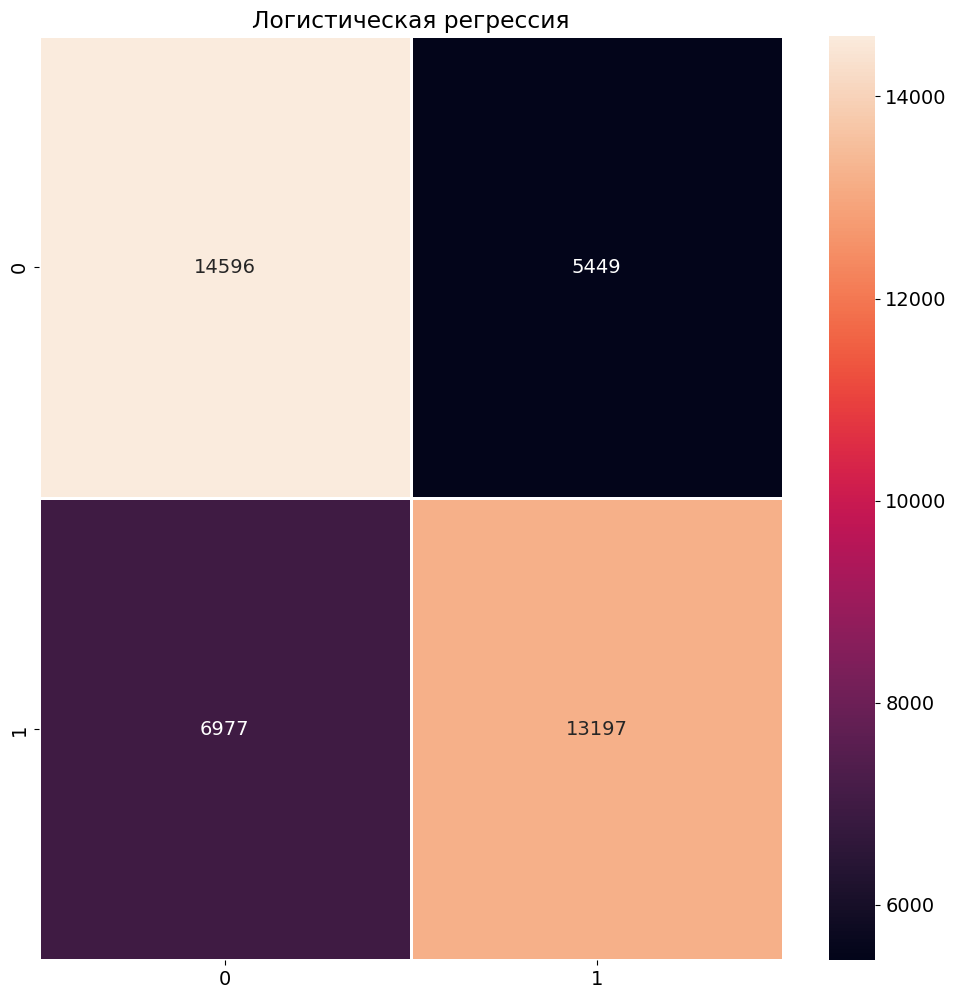

In [42]:

lr = LogisticRegression()
lr.fit(x_train_balanced, y_train_balanced)

y_pred = lr.predict(x_test_balanced)
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Логистическая регрессия')

In [43]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.6910 
    Precision:0.7078
    Recall:0.6542
    F1: 0.6799
    AUC: 0.6912
    
    


In [44]:
# param_grid = {
#     'C': [0.01, 0.1, 1.0, 10.0, 20.0, 30.0],  
#     'tol':[0.0001, 0.001, 0.01, 0.1],
#     'penalty': ['l1', 'l2'],                    
# }

# grid_search = GridSearchCV(
#     estimator=cuml.LogisticRegression(),
#     param_grid=param_grid,
#     scoring='accuracy',           # Метрика для оценки
#     cv=5,                         # Количество фолдов для кросс-валидации
#     verbose=2,                    # Уровень детализации вывода
#     n_jobs=-1                     # Использование всех доступных ядер CPU
# )

# grid_search.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

# # Вывод лучших параметров и соответствующей точности
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшая точность на кросс-валидации:", grid_search.best_score_)
# best_model = grid_search.best_estimator_


In [45]:
# y_pred = best_model.predict(x_test_balanced)

In [46]:
# classification_report(y_test_balanced, y_pred)
# show_confusion_matrix(y_test_balanced, y_pred, 'LogisticRegression с подбором параметров')

## Random Forest

              precision    recall  f1-score   support

           0       0.64      0.80      0.71     20045
           1       0.73      0.55      0.63     20174

    accuracy                           0.67     40219
   macro avg       0.68      0.67      0.67     40219
weighted avg       0.68      0.67      0.67     40219

AUC: 0.6738526799879214


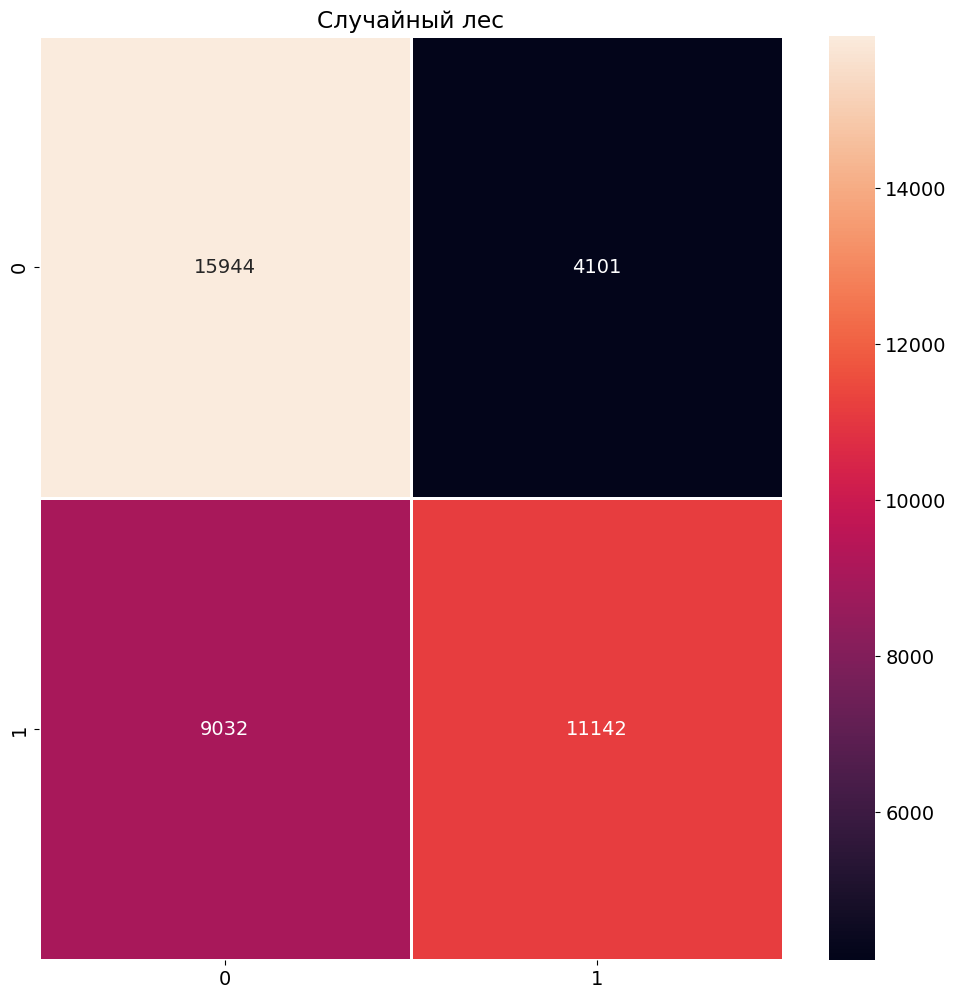

In [47]:
from cuml.ensemble import RandomForestClassifier 

rf = RandomForestClassifier()

rf.fit(x_train_balanced, y_train_balanced)

y_pred = rf.predict(x_test_balanced)
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Случайный лес')


In [48]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.6735 
    Precision:0.7310
    Recall:0.5523
    F1: 0.6292
    AUC: 0.6739
    
    


In [49]:
# param_grid = {
#     'n_estimators': [100, 150, 250, 300],  
#     'split_criterion':[0,1],
#     'max_depth': [16, 32, 64],
#     'max_leaves':[2,4,8,16,32]
# }

# grid_search = GridSearchCV(
#     estimator=cuml.RandomForestClassifier(),
#     param_grid=param_grid,
#     scoring='accuracy',           # Метрика для оценки
#     cv=3,                         # Количество фолдов для кросс-валидации
#     verbose=1,                    # Уровень детализации вывода
#     n_jobs=-1                     # Использование всех доступных ядер CPU
# )

# grid_search.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

# # Вывод лучших параметров и соответствующей точности
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшая точность на кросс-валидации:", grid_search.best_score_)
# best_model = grid_search.best_estimator_

In [50]:
# y_pred = best_model.predict(x_test_balanced)
# classification_report(y_test_balanced, y_pred)
# show_confusion_matrix(y_test_balanced, y_pred, 'RandomForest')

## SVM

SVM:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70     20045
           1       0.71      0.63      0.67     20174

    accuracy                           0.68     40219
   macro avg       0.69      0.68      0.68     40219
weighted avg       0.69      0.68      0.68     40219

AUC: 0.6846874558514779


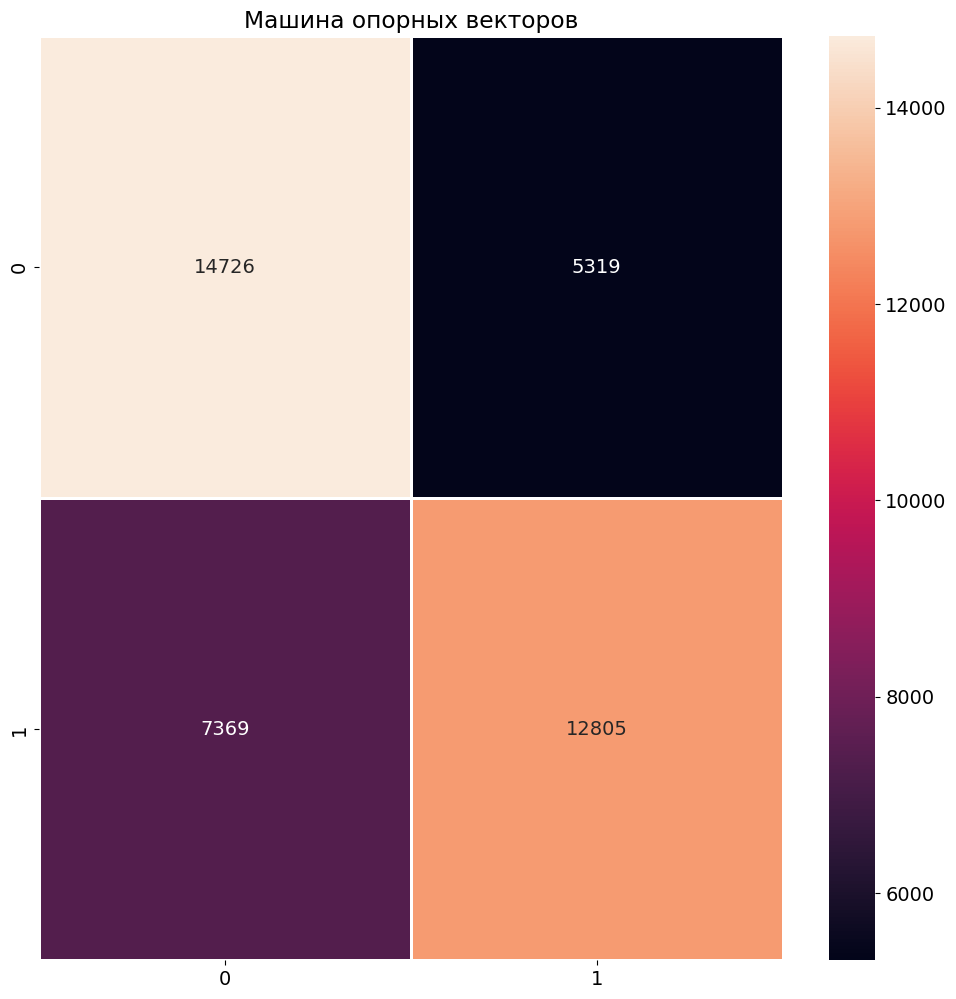

In [51]:
from cuml.svm import LinearSVC

svc = LinearSVC()

svc.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())

y_pred = svc.predict(x_test_balanced)
print('SVM:')
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Машина опорных векторов')


In [52]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.6845 
    Precision:0.7065
    Recall:0.6347
    F1: 0.6687
    AUC: 0.6847
    
    


## MBSGDClassifier

In [53]:
from cuml import MBSGDClassifier

mbsgd = MBSGDClassifier()

mbsgd.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())

MBSGDClassifier()

MBSGDClassifier:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     20045
           1       0.67      0.72      0.69     20174

    accuracy                           0.68     40219
   macro avg       0.68      0.68      0.68     40219
weighted avg       0.68      0.68      0.68     40219

AUC: 0.6819454260035471


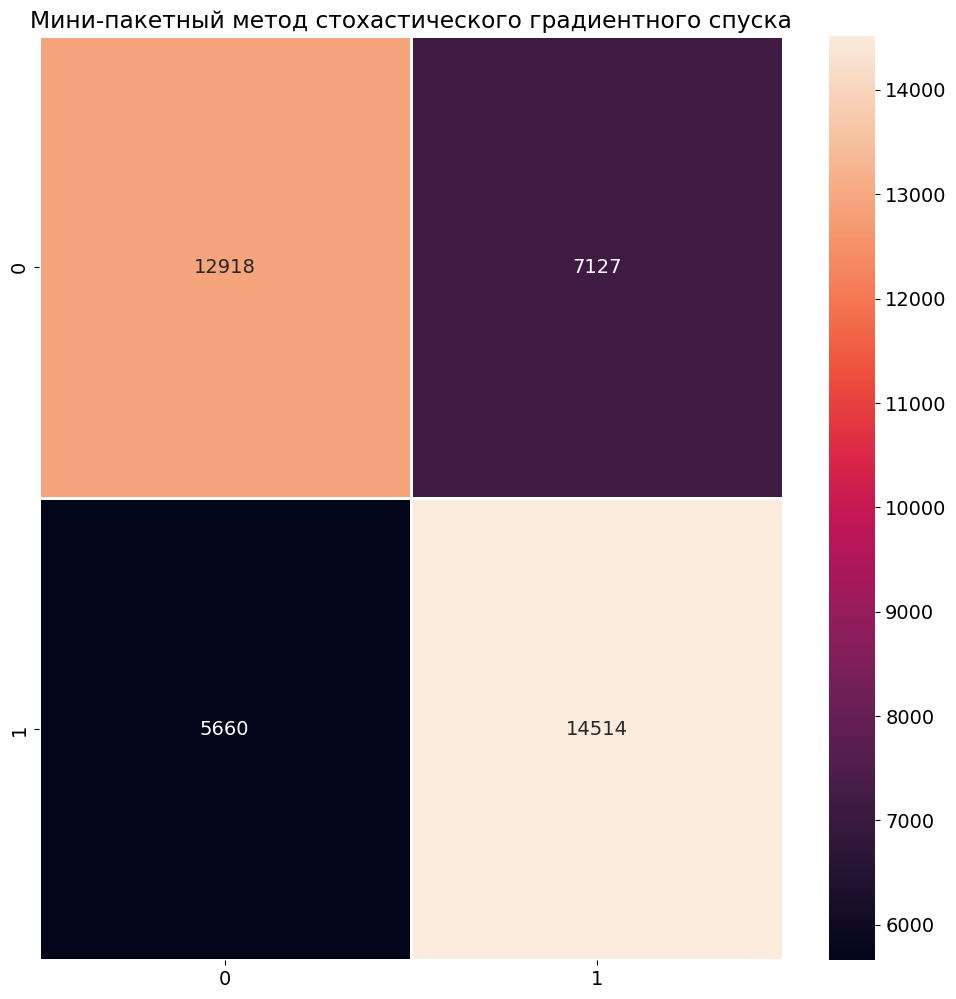

In [54]:
y_pred = mbsgd.predict(x_test_balanced)
print('MBSGDClassifier:')

classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Мини-пакетный метод стохастического градиентного спуска')

In [55]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.6821 
    Precision:0.6707
    Recall:0.7194
    F1: 0.6942
    AUC: 0.6819
    
    


## Naive Bayes

              precision    recall  f1-score   support

           0       0.65      0.74      0.69     20045
           1       0.70      0.60      0.65     20174

    accuracy                           0.67     40219
   macro avg       0.67      0.67      0.67     40219
weighted avg       0.67      0.67      0.67     40219

AUC: 0.6700206878134783


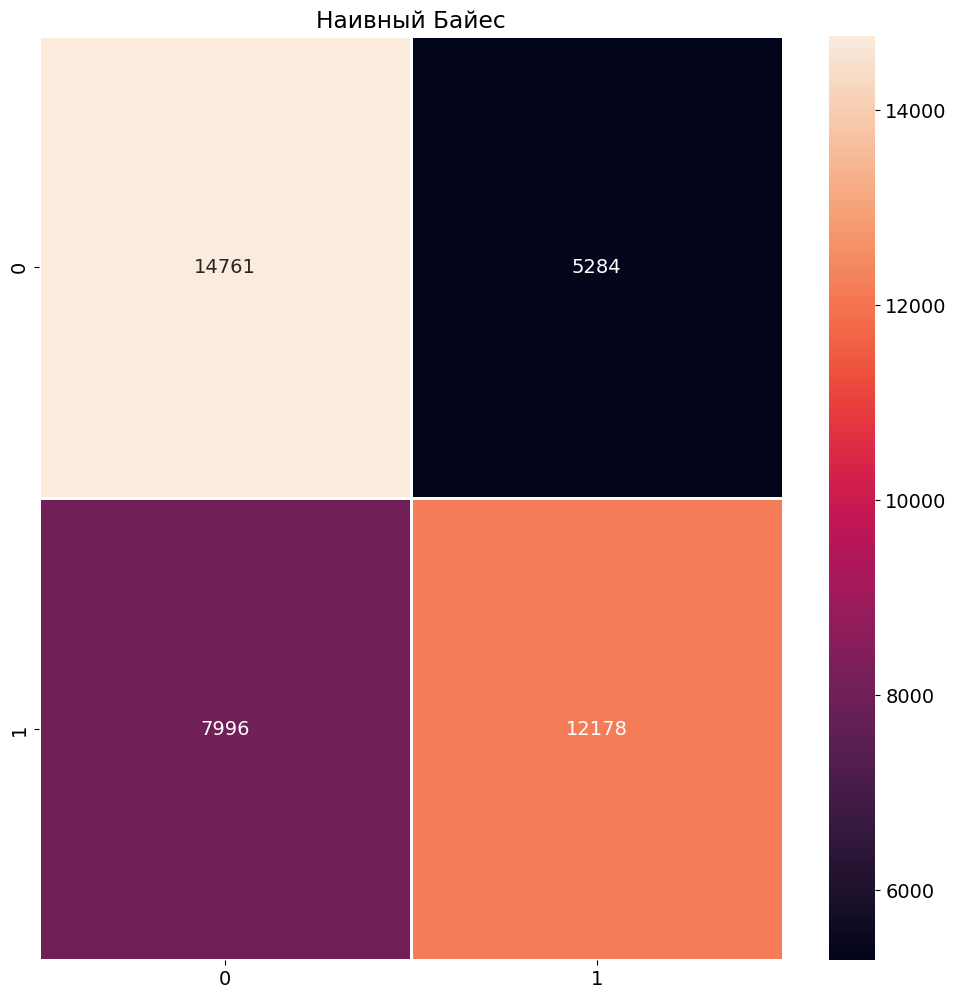

In [56]:
from cuml.naive_bayes import ComplementNB

nb = ComplementNB()

nb.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())
y_pred = nb.predict(x_test_balanced.to_cupy())

classification_report(y_test_balanced.to_cupy(), y_pred)
show_confusion_matrix(y_test_balanced.to_cupy(), y_pred, 'Наивный Байес')

In [57]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.6698 
    Precision:0.6974
    Recall:0.6036
    F1: 0.6471
    AUC: 0.6700
    
    


## KNeighborsClassifier

KNN:
              precision    recall  f1-score   support

           0       0.52      0.95      0.67     20045
           1       0.70      0.12      0.21     20174

    accuracy                           0.53     40219
   macro avg       0.61      0.53      0.44     40219
weighted avg       0.61      0.53      0.44     40219

AUC: 0.534057514787228


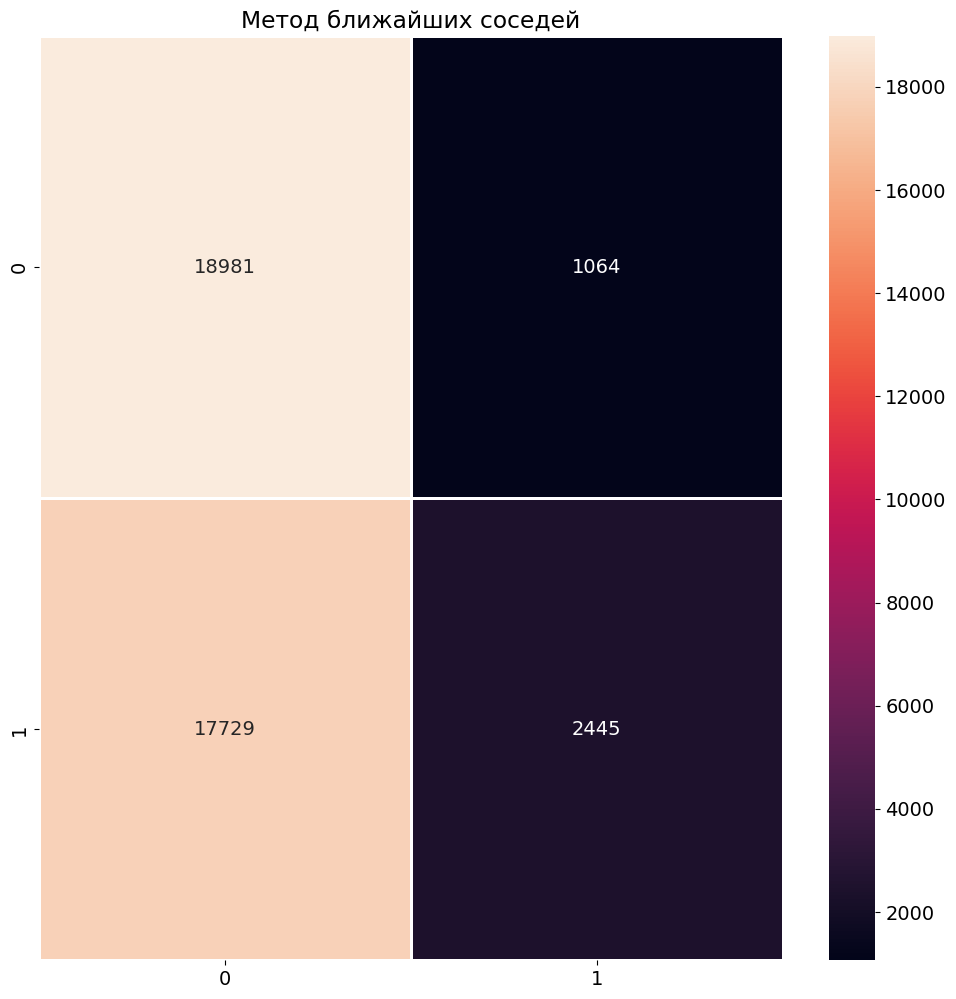

In [58]:
from cuml.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())
y_pred = knn.predict(x_test_balanced)
print('KNN:')

classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Метод ближайших соседей')

In [59]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.5327 
    Precision:0.6968
    Recall:0.1212
    F1: 0.2065
    AUC: 0.5341
    
    


## Voting классификатор

In [60]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        # ('svc', svc),
        ('mbsdg', mbsgd),
        ('nb', nb),
        # ('knn', knn)
    ],
    voting='hard' 
)

In [61]:
voting_clf.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('mbsdg', MBSGDClassifier()),
                             ('nb', ComplementNB())])

In [62]:
# print("Тип данных для LR:", lr.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для RF:", rf.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для SVC:", svc.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для MBSGD:", mbsgd.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для NB:", nb.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для KNN:", knn.predict(review_vector_test.todense().get()).dtype)

Voting classifier:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71     20045
           1       0.73      0.60      0.66     20174

    accuracy                           0.69     40219
   macro avg       0.70      0.69      0.69     40219
weighted avg       0.70      0.69      0.69     40219

AUC: 0.6891129611887677


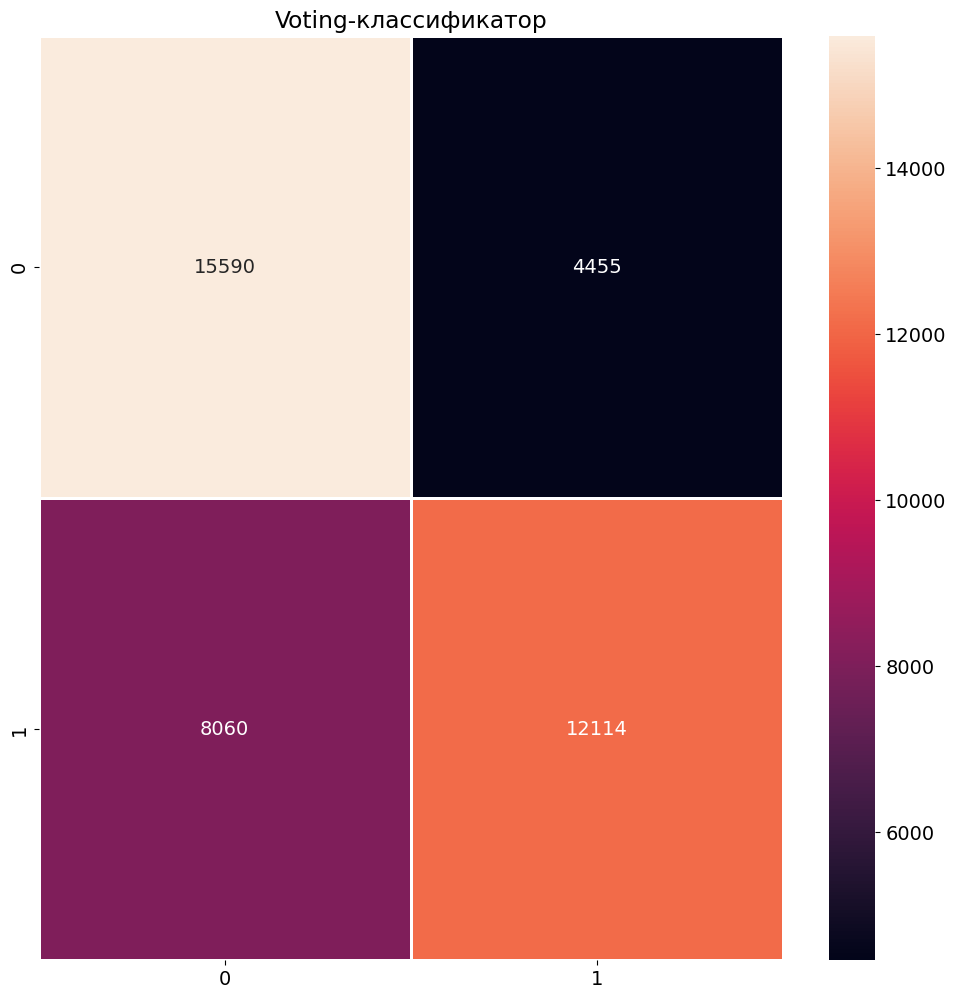

In [63]:
y_pred = voting_clf.predict(x_test_balanced.to_cupy().get())
print('Voting classifier:')
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Voting-классификатор')

In [64]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.6888 
    Precision:0.7311
    Recall:0.6005
    F1: 0.6594
    AUC: 0.6891
    
    


# Сохранение сбалансированного датасета в файл

## TF-IDF векторы 

In [65]:
x_balanced.shape, y_balanced.shape

((160878, 1000), (160878,))

In [66]:
y_balanced.value_counts()

label
0    80439
1    80439
Name: count, dtype: int64

In [67]:
x_balanced.to_csv('yelp_zip_X_tf_idf_balanced.csv')

In [68]:
cudf.DataFrame(y_balanced)

,label
308413,1
139875,1
264793,1
161916,1
196959,1
...,...
608443,0
608446,0
608447,0
608448,0


In [69]:
cudf.DataFrame(y_balanced).to_csv('yelp_zip_y_labels_balanced.csv')

## Выборка из исходного датафрейма

In [70]:
balanced_origin_df = df_origin.loc[df_indices]
balanced_origin_df

,Unnamed: 0,user_id,prod_id,rating,label,date,review,prod_name
308413,308413,29488,1123,5.0,1,2012-07-22,Supper = FRANK = YUM Black Kale appetizer Spag...,Supper
139875,139875,96030,1298,2.0,1,2014-02-13,My experience at ABC Kitchen was totally under...,ABC Kitchen
264793,264793,150935,2265,4.0,1,2010-06-06,Any place that gives me fried chicken with tuf...,Pies-n-Thighs
161916,161916,28560,1423,4.0,1,2014-08-27,"Oh, Burrito Bar, our decade long relationship...",Burrito Bar
196959,196959,122354,1761,4.0,1,2014-09-27,"Verlaine is such a fun, relaxed place for cock...",Verlaine
...,...,...,...,...,...,...,...,...
30202,30202,10928,237,4.0,1,2009-10-29,A couple of years ago Silk City overhauled its...,Silk City Diner & Lounge
256041,256041,5180,2218,5.0,1,2012-02-19,My rating is for the scrumptious donuts; they ...,Orangeside On Temple
178186,178186,27493,1574,4.0,1,2011-06-06,"Only in New York..... Only in New York, do you...",La Sirene
388737,388737,55211,3294,3.0,1,2012-06-16,The price was great. Service - okay. Food - ...,Bodhi Tree


In [71]:
balanced_origin_df['label'].value_counts()

label
1    80439
Name: count, dtype: int64

In [72]:
origin_fake = df_origin[df_origin['label'] == -1]

In [73]:
balanced_origin_df=  cudf.concat([balanced_origin_df, origin_fake], axis=0)
balanced_origin_df

,Unnamed: 0,user_id,prod_id,rating,label,date,review,prod_name
308413,308413,29488,1123,5.0,1,2012-07-22,Supper = FRANK = YUM Black Kale appetizer Spag...,Supper
139875,139875,96030,1298,2.0,1,2014-02-13,My experience at ABC Kitchen was totally under...,ABC Kitchen
264793,264793,150935,2265,4.0,1,2010-06-06,Any place that gives me fried chicken with tuf...,Pies-n-Thighs
161916,161916,28560,1423,4.0,1,2014-08-27,"Oh, Burrito Bar, our decade long relationship...",Burrito Bar
196959,196959,122354,1761,4.0,1,2014-09-27,"Verlaine is such a fun, relaxed place for cock...",Verlaine
...,...,...,...,...,...,...,...,...
608443,608443,265316,5042,5.0,-1,2014-12-24,I have been to this place for the third time i...,Ramayana Restaurant
608446,608446,247830,5039,3.0,-1,2011-12-03,Best Subs does offer a large portione size how...,Best Subs the
608447,608447,265318,5039,4.0,-1,2015-01-02,todays marks my 10th visit and have not had a ...,Best Subs the
608448,608448,100625,5039,4.0,-1,2013-11-02,"The name says it all! Also, they make some kil...",Best Subs the


In [74]:
balanced_origin_df.to_csv('yelp_zip_kmeans_balancing.csv')